<center><img width="350"  align="right" src="attachment:DSME_logo.png" /></center>

**Reinforcement Learning** <br> 
RWTH Aachen University, DSME (Prof. Sebastian Trimpe, Paul Brunzema) <br>

# Dynamic Programming for the Recycle Robot Environment

(Implementation of Example 3.3 in Sutton & Barto textbook, 2nd edition.)

<img src="./images/RecyclingRobot_mod.jpg" 
     align="center" 
     width="800" />

### Imports

In [1]:
from gymnasium import Env, spaces
from gymnasium.envs.toy_text.utils import categorical_sample
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
random.seed(5)  # random
%matplotlib inline

## Create MDP for the Recycling Robot

In [2]:
class RecycleEnv(Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, alpha=0.5, beta=0.2, duration=20, render_mode=None):
        self.observation_space = spaces.Discrete(2)  # 0: low 1: high
        self.action_space = spaces.Discrete(3)  # 0: search 1: wait 2: recharge

        r_search = 3
        r_wait = 1
        self.state = "high"
        self.sum = 0

        self.StateActionPairings = {"low": ["search", "wait", "recharge"],
                                    "high": ["search", "wait"]}

        # action: {state:[(nextstate, reward, probability, termination)]}
        self.TransitionStatesandProbs = {
            "wait": {
                "high": [("high", r_wait, 1, False)],
                "low": [("low", r_wait, 1, False)]
            },
            "recharge": {
                "low": [("high", 0, 1, False)]
            },
            "search": {
                "high": [("high", r_search, round(alpha, 1), False),
                         ("low", r_search, round(1-alpha, 1), False)],
                "low": [("low", r_search, round(beta, 1), False),
                        ("high", -3, round(1-beta, 1), False)]
            }}

    def reset(self, seed=None, options: Optional[dict] = None):
        self.state = "high"
        self.time = 0
        self.sum = 0
        print("Environment reset: Current state is High")
        return self.state, {}

    def step(self, a):
        print(a)
        transitions = self.TransitionStatesandProbs[a][self.state]
        i = categorical_sample([t[2] for t in transitions], self.np_random)
        s, r, p, t = transitions[i]
        self.SumReward(r)
        self.state = s
        return (s, r, t, False, {})

    def SumReward(self, reward=0):
        self.sum = self.sum + reward
        return self.sum

    def getPossibleActions(self, state):
        return self.StateActionPairings[state]

    def getTransitionStatesandProbs(self, state, action):
        return self.TransitionStatesandProbs[action][state]

## Agent using Value Iteration to find the optimal policy

In [3]:
class ValueIterationAgent():
    def __init__(self, env, discount=0.9, iterations=100, theta=0.01):
        self.name = "Value Iteration Agent"
        self.env = env
        self.discount = discount
        self.theta = theta
        self.V = {"low": 0, "high": 0}
        self.pi = {}

        # train
        self.train(iterations)

    def train(self, iterations):
        states = ["low", "high"]  # states are numbered
        for i in range(iterations):
            delta = 0

            for state in states:
                v = self.V[state]
                actions = self.env.getPossibleActions(state)
                value_list = []
                for action in actions:
                    val_sum = 0
                    for sum_element in self.env.getTransitionStatesandProbs(state, action):

                        # Extract information
                        next_state = sum_element[0]
                        reward = sum_element[1]
                        trans_prob = sum_element[2]

                        # Compute sum
                        val_sum = val_sum + trans_prob*(reward + self.discount*self.V[next_state])
                    value_list.append(val_sum)

                # Update value function
                self.V[state] = max(value_list)

                # Update delta
                delta = max(delta, abs(v - self.V[state]))

                # explicit "policy improvement"
                self.pi[state] = actions[value_list.index(self.V[state])]

            # stopping criterion
            if delta < self.theta:
                print(f"Stopping criterion satisfied after {i} iterations.\n")
                print(f"Value function is: {self.V}\n")
                print(f"Optimal policy is: {self.pi}\n")
                break

    def getValue(self, state):
        return self.V[state]

    def getPolicy(self, state):
        return self.pi[state]

    def getAction(self, state):
        return self.getPolicy(state)

## Dummy Agent using the random policy


In [4]:
class DummyAgent():
    def __init__(self, env):
        self.name = "Dummy Agent"
        self.env = env

    def getValue(self, state):
        pass

    def getPolicy(self, state):
        actions = self.env.getPossibleActions(state)
        return random.choice(actions)

    def getAction(self, state):
        return self.getPolicy(state)

### Define play-function

In [5]:
# Lets Play
def play(agent, env, rounds=100, render=False):
    print("#"*10, "\n")
    print(f"Starting play with agent: {agent.name}\n")

    for round_no in range(rounds):
        current_state = env.state
        player_move = agent.getAction(current_state)
        next_state, r, t, _, _ = env.step(player_move)

        print(f"Round {round_no} \nAction: {player_move}\tReward: {r}\tNext State: {next_state}")
        img = Image.open("./images/"+current_state+"_"+player_move+"_"+next_state+".jpg")
        plt.figure(figsize=(10, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        input("Press Enter to continue!")

    print(f"{rounds} Rounds Ended:\n")
    print(f"The agent collected a total return of {env.sum}\n")
    env.reset()
    print("#"*10, "\n")

## Dummy Agent

In [6]:
env = RecycleEnv()

########## 

Starting play with agent: Dummy Agent

wait
Round 0 
Action: wait	Reward: 1	Next State: high


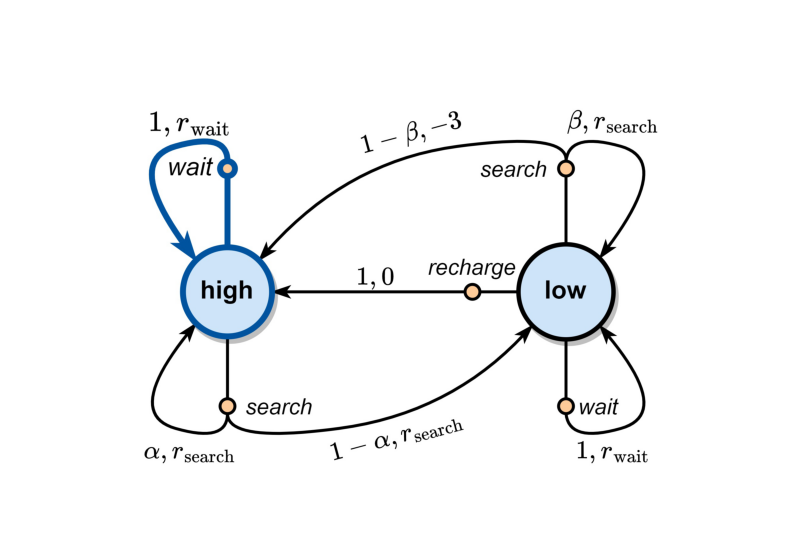

Press Enter to continue! 


wait
Round 1 
Action: wait	Reward: 1	Next State: high


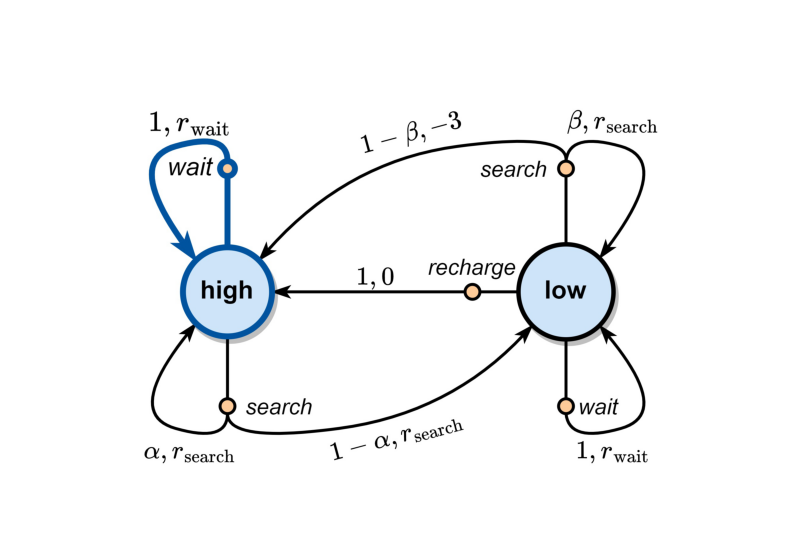

Press Enter to continue! 


search
Round 2 
Action: search	Reward: 3	Next State: low


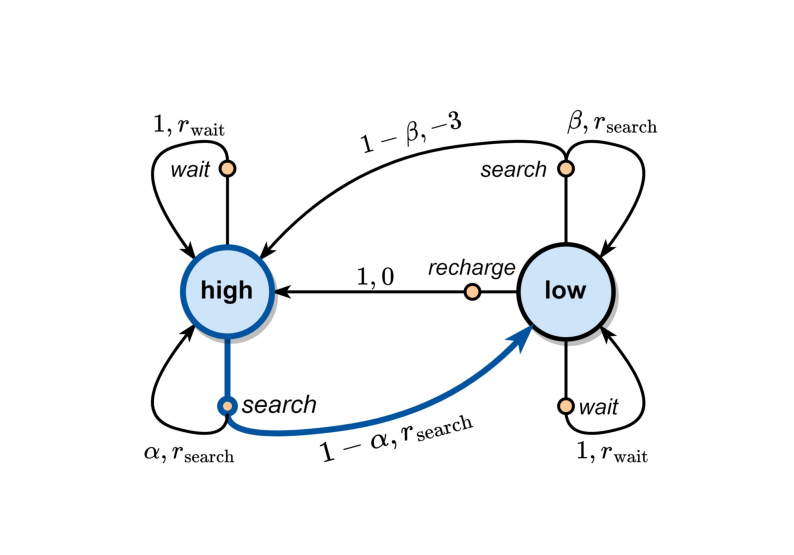

Press Enter to continue! 


wait
Round 3 
Action: wait	Reward: 1	Next State: low


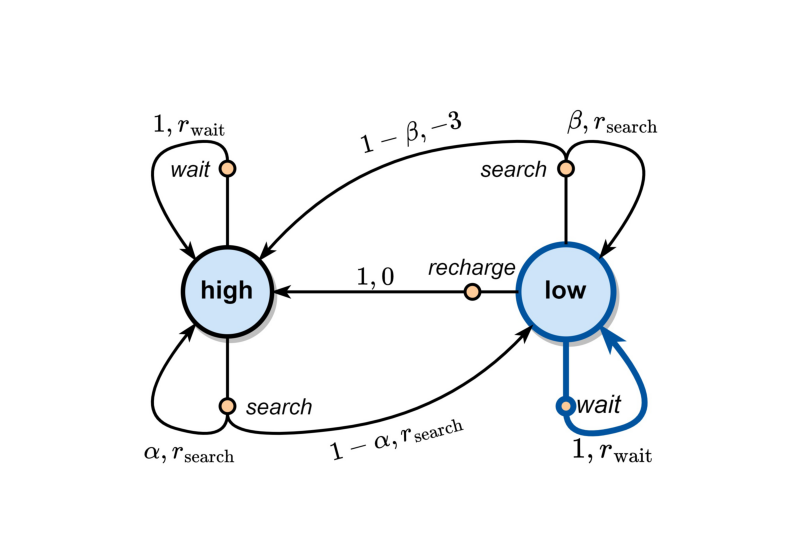

Press Enter to continue! 


search
Round 4 
Action: search	Reward: -3	Next State: high


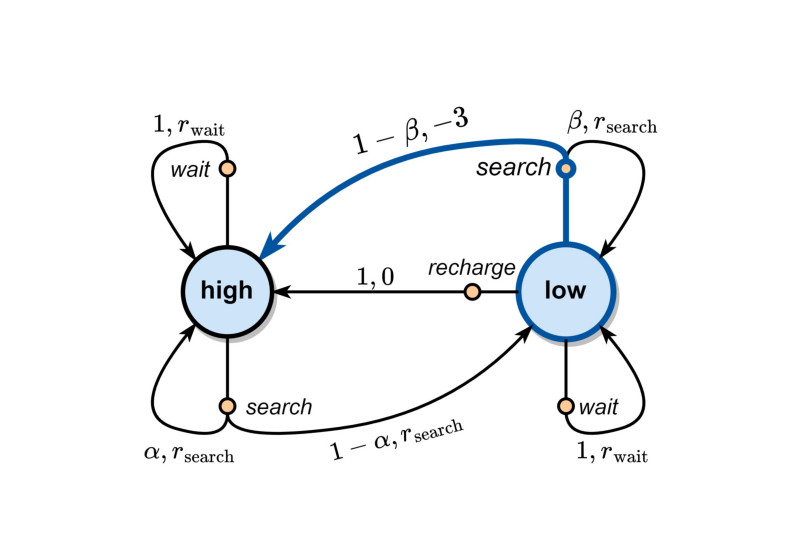

Press Enter to continue! 


search
Round 5 
Action: search	Reward: 3	Next State: low


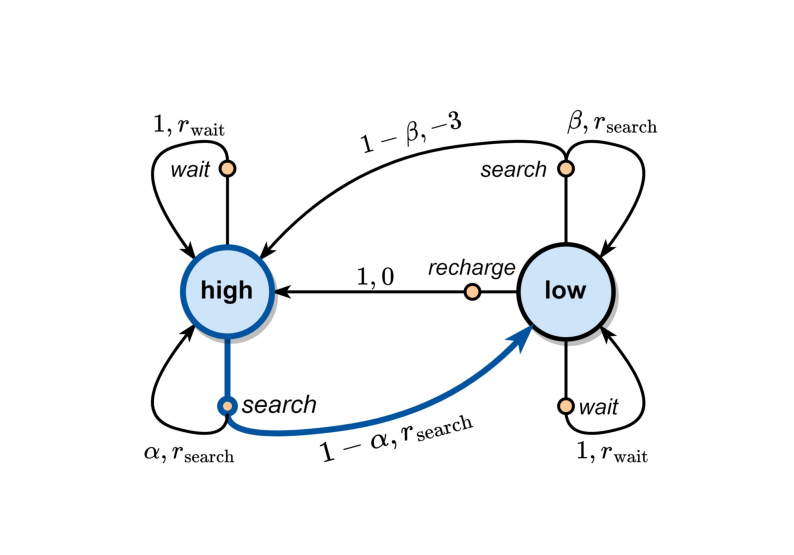

Press Enter to continue! 


search
Round 6 
Action: search	Reward: 3	Next State: low


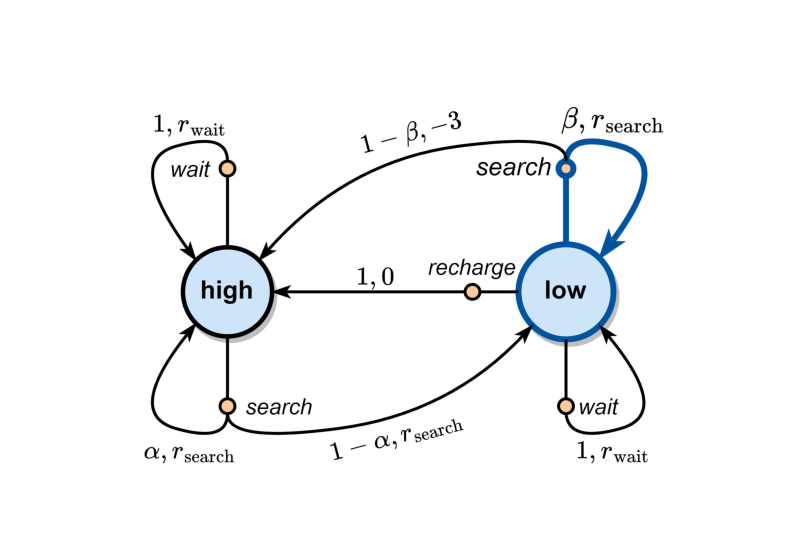

Press Enter to continue! 


search
Round 7 
Action: search	Reward: -3	Next State: high


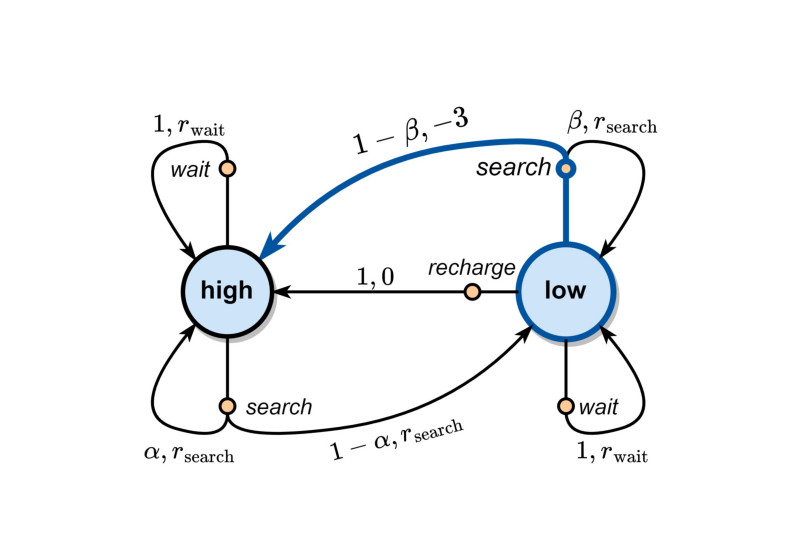

Press Enter to continue! 


wait
Round 8 
Action: wait	Reward: 1	Next State: high


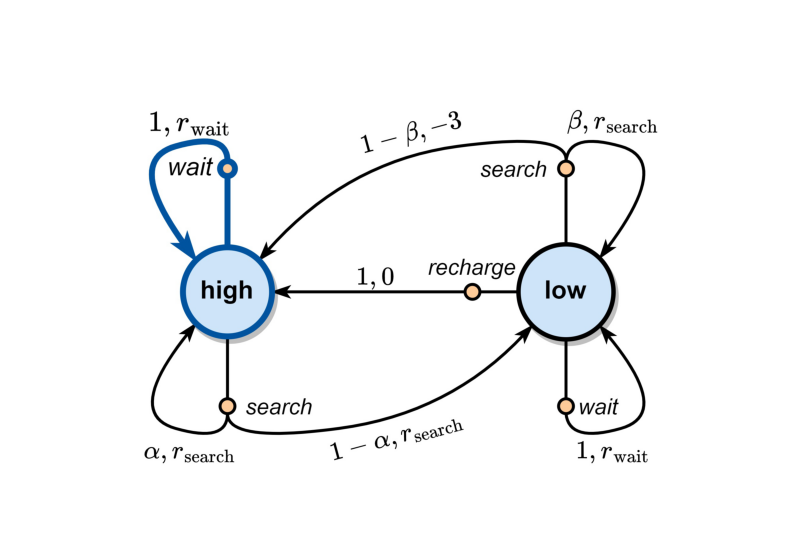

Press Enter to continue! 


wait
Round 9 
Action: wait	Reward: 1	Next State: high


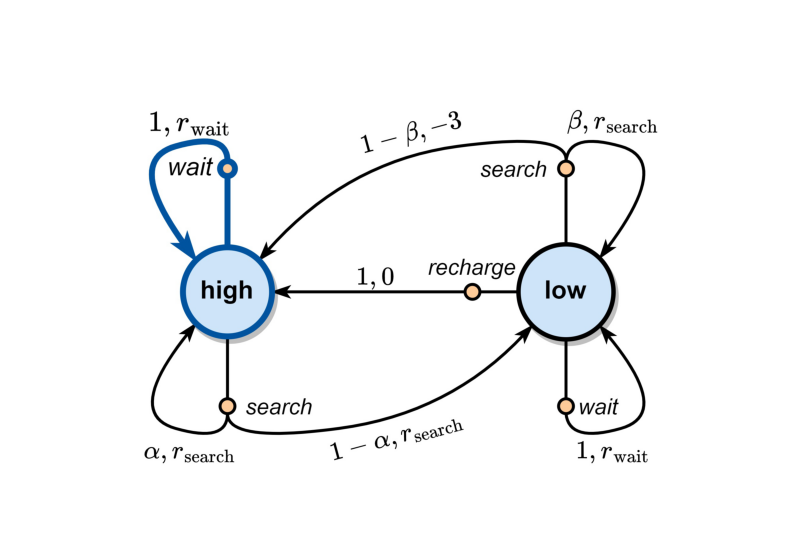

Press Enter to continue! 


10 Rounds Ended:

The agent collected a total return of 8

Environment reset: Current state is High
########## 



In [7]:
agent = DummyAgent(env)
play(agent, env, rounds=10)

## Value Iteration Agent

Stopping criterion satisfied after 37 iterations.

Value function is: {'low': 18.5655389316313, 'high': 20.637261985049733}

Optimal policy is: {'low': 'recharge', 'high': 'search'}

########## 

Starting play with agent: Value Iteration Agent

search
Round 0 
Action: search	Reward: 3	Next State: low


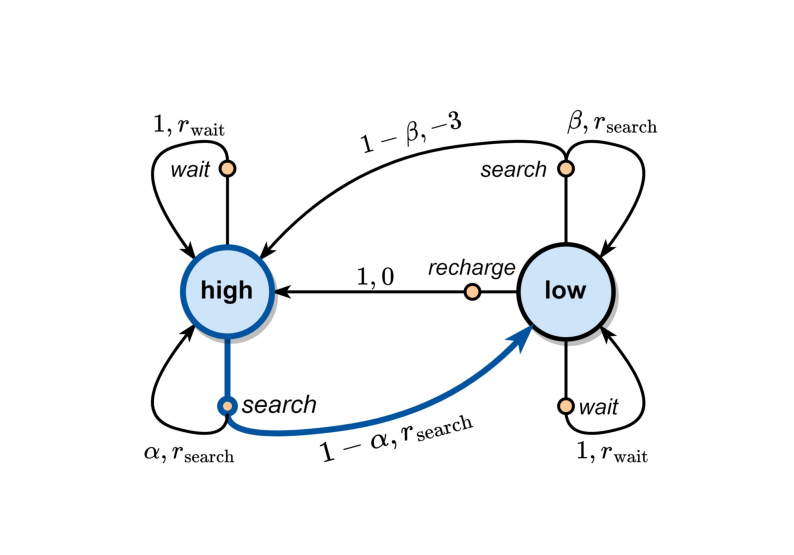

Press Enter to continue! 


recharge
Round 1 
Action: recharge	Reward: 0	Next State: high


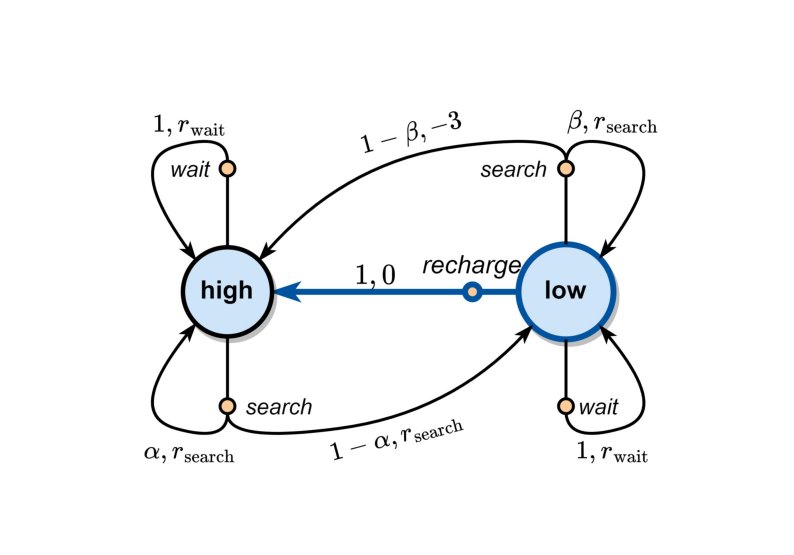

Press Enter to continue! 


search
Round 2 
Action: search	Reward: 3	Next State: low


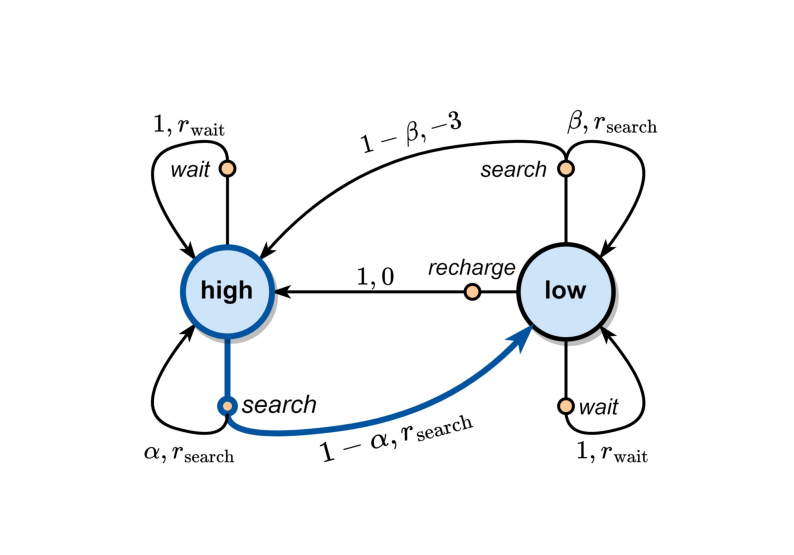

Press Enter to continue! 


recharge
Round 3 
Action: recharge	Reward: 0	Next State: high


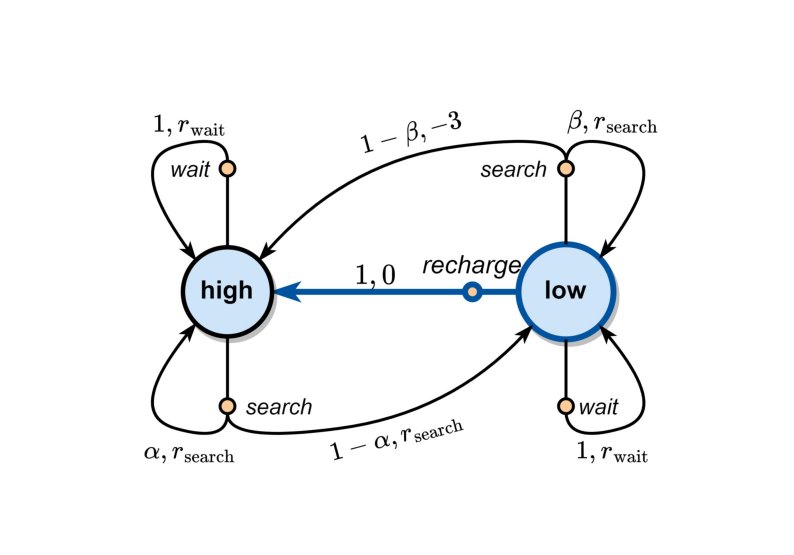

Press Enter to continue! 


search
Round 4 
Action: search	Reward: 3	Next State: high


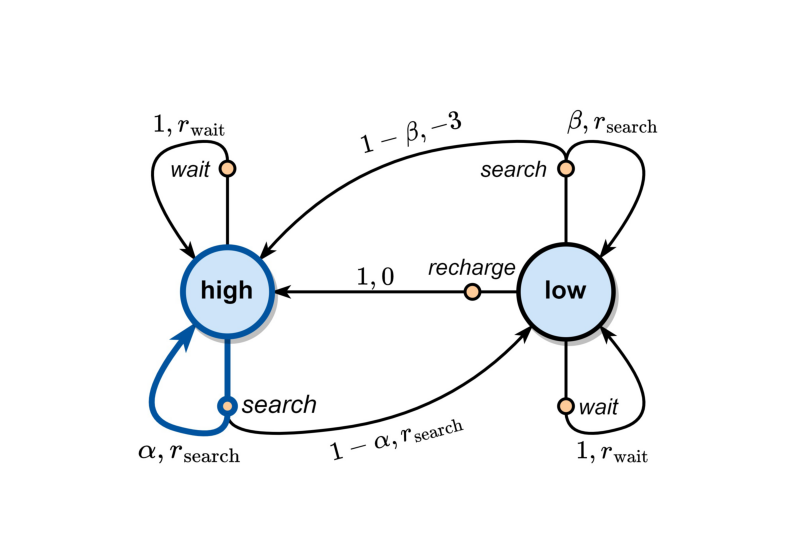

Press Enter to continue! 


search
Round 5 
Action: search	Reward: 3	Next State: low


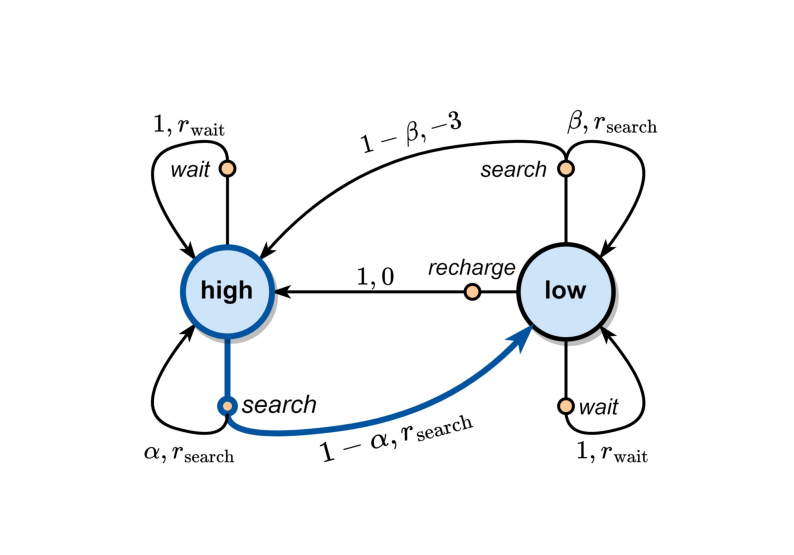

Press Enter to continue! 


recharge
Round 6 
Action: recharge	Reward: 0	Next State: high


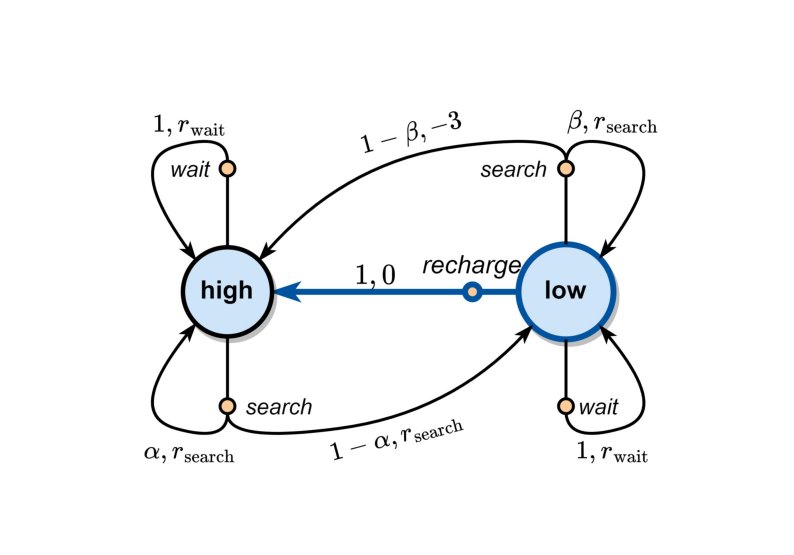

Press Enter to continue! 


search
Round 7 
Action: search	Reward: 3	Next State: high


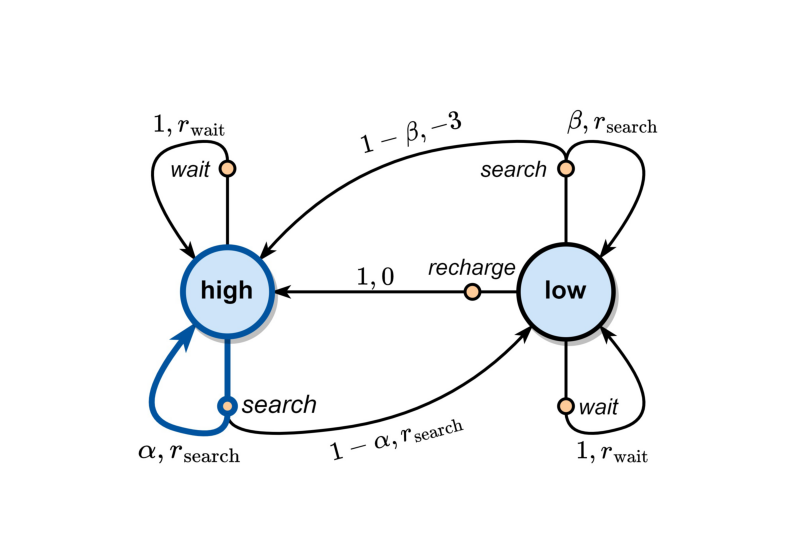

Press Enter to continue! 


search
Round 8 
Action: search	Reward: 3	Next State: low


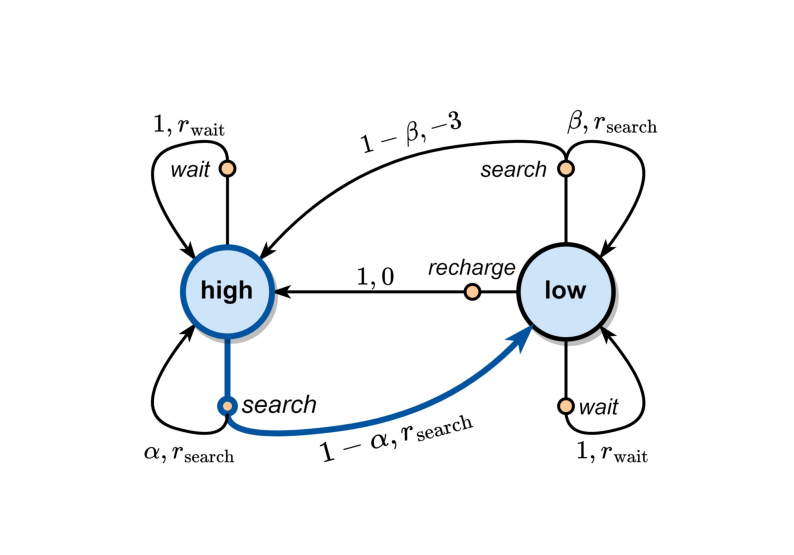

Press Enter to continue! 


recharge
Round 9 
Action: recharge	Reward: 0	Next State: high


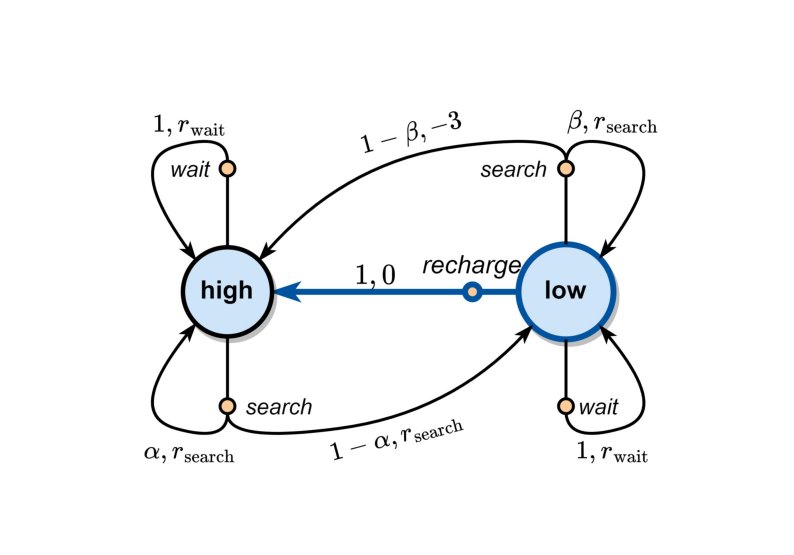

Press Enter to continue! 


10 Rounds Ended:

The agent collected a total return of 18

Environment reset: Current state is High
########## 



In [8]:
agent = ValueIterationAgent(env=env)
play(agent, env, rounds=10)